In [1]:
import torch
import numpy as np
import pandas as pd
from pytorch_lightning import Trainer
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping

from lightning_models import ForecastNextKDays
from torchinfo import summary

In [2]:
model = ForecastNextKDays(data_path = 'Dataset\IKCO1.csv',
                        split = [0.80, 0.10, 0.10],
                        batch_size = 64,       
                        learning_rate = 3e-4,
                        weight_decay = 0,
                        input_size = 5,
                        hidden_size = 128,
                        k_days = 10,
                        num_layers = 4,
                        prob = 0,
                        timestep = 20)


summary(model, input_size = (64, 20, 5))

Layer (type:depth-idx)                   Output Shape              Param #
ForecastNextKDays                        --                        --
├─forecastLSTM: 1-1                      [64, 1]                   --
│    └─LSTM: 2-1                         [64, 20, 128]             465,408
│    └─Linear: 2-2                       [64, 1]                   129
│    └─Dropout: 2-3                      [64, 1]                   --
├─MSELoss: 1-2                           --                        --
├─MeanAbsoluteError: 1-3                 --                        --
├─MeanSquaredError: 1-4                  --                        --
Total params: 465,537
Trainable params: 465,537
Non-trainable params: 0
Total mult-adds (M): 595.73
Input size (MB): 0.03
Forward/backward pass size (MB): 1.31
Params size (MB): 1.86
Estimated Total Size (MB): 3.20

In [3]:
checkpoint_callback = ModelCheckpoint(dirpath = 'forecast',
                                    filename = "checkpoint.ckpt",
                                    every_n_epochs = 1,
                                    monitor = 'val_loss',
                                    mode = 'min')

early_stop_callback = EarlyStopping(monitor = "val_loss",
                                    min_delta = 0.00,
                                    patience = 12,
                                    verbose = False,
                                    mode = "min")


logger = TensorBoardLogger('forecast-logs/', name = 'forecast', version = 0)

In [4]:
trainer = Trainer(
    default_root_dir = 'forecast-logs/',
    gpus = (1 if torch.cuda.is_available() else 0),
    callbacks = [checkpoint_callback],
    max_epochs = 100,
    logger = logger)

trainer.fit(model = model)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                | Type              | Params
----------------------------------------------------------
0 | model               | forecastLSTM      | 465 K 
1 | loss                | MSELoss           | 0     
2 | mean_absolute_error | MeanAbsoluteError | 0     
3 | mean_squared_error  | MeanSquaredError  | 0     
----------------------------------------------------------
465 K     Trainable params
0         Non-trainable params
465 K     Total params
1.862     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

c:\Anaconda\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:240: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


c:\Anaconda\lib\site-packages\torch\nn\modules\loss.py:529: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\Anaconda\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:240: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Epoch 27:   0%|          | 0/55 [00:00<?, ?it/s, loss=0.00278, v_num=0, train_loss=0.00597]         

c:\Anaconda\lib\site-packages\pytorch_lightning\trainer\trainer.py:724: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


In [5]:
trainer.test(model)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Anaconda\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:240: PossibleUserWarning: The dataloader, test_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing DataLoader 0: 100%|██████████| 5/5 [00:00<00:00, 53.89it/s]m=0, train_loss=0.00597]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
           MAE              0.18946997821331024
           MSE              0.0567631721496582
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'MAE': 0.18946997821331024, 'MSE': 0.0567631721496582}]

In [7]:
from utils import transform_data, create_dataset

model = model.load_from_checkpoint("forecast\checkpoint.ckpt.ckpt")
df = pd.read_csv('Dataset\IKCO1.csv', index_col = [0])

df_X = df[['<OPEN>','<HIGH>','<LOW>','<CLOSE>','<VOL>']] 
df_y = df[['<CLOSE>']]

df_X_scaled = model.scaler_X.transform(df_X)


inputs, actuals = create_dataset(df_X_scaled, df_y, 20, 1)

In [8]:
print(inputs.shape, actuals.shape)

(4076, 20, 5) (4076,)


In [9]:
inputs = torch.tensor(inputs.astype(np.float32))
inputs

tensor([[[ 2.0843e-01,  1.7390e-01,  2.1794e-01,  2.0865e-01,  4.3901e-04],
         [ 2.0865e-01,  1.7462e-01,  2.1783e-01,  2.0843e-01,  3.8199e-04],
         [ 2.0843e-01,  1.7372e-01,  2.1760e-01,  2.0811e-01,  6.6190e-04],
         ...,
         [ 2.3943e-01,  2.0072e-01,  2.4602e-01,  2.3911e-01,  4.0524e-03],
         [ 2.3911e-01,  2.0054e-01,  2.4992e-01,  2.3976e-01,  1.9753e-03],
         [ 2.3976e-01,  2.0342e-01,  2.5036e-01,  2.4405e-01,  2.8186e-03]],

        [[ 2.0865e-01,  1.7462e-01,  2.1783e-01,  2.0843e-01,  3.8199e-04],
         [ 2.0843e-01,  1.7372e-01,  2.1760e-01,  2.0811e-01,  6.6190e-04],
         [ 2.0811e-01,  1.7813e-01,  2.1772e-01,  2.1390e-01,  3.1825e-04],
         ...,
         [ 2.3911e-01,  2.0054e-01,  2.4992e-01,  2.3976e-01,  1.9753e-03],
         [ 2.3976e-01,  2.0342e-01,  2.5036e-01,  2.4405e-01,  2.8186e-03],
         [ 2.4405e-01,  2.1746e-01,  2.5493e-01,  2.6078e-01,  3.7331e-04]],

        [[ 2.0843e-01,  1.7372e-01,  2.1760e-01,  2.0811

In [10]:
model.eval()
with torch.no_grad():
    
    output = model(inputs) 

preds = output.squeeze()
preds = np.array(preds) 
preds

array([0.22697996, 0.22782879, 0.22983022, ..., 0.16173545, 0.1675038 ,
       0.17264004], dtype=float32)

In [11]:
print(preds.shape)

(4076,)


In [12]:
predictions = pd.DataFrame(preds, columns = ['preds'])
predictions[['preds']] = model.scaler_y.inverse_transform(predictions[['preds']])

In [13]:
predictions['actuals'] = df_y['<CLOSE>']
predictions.head(10)

,preds,actuals
0,2970.906982,2800.0
1,2978.819824,2798.0
2,2997.477295,2795.0
3,3028.836914,2849.0
4,3068.356445,2838.0
5,3108.566162,2868.0
6,3141.489502,2900.0
7,3162.136963,3004.0
8,3173.490967,3102.0
9,3182.597656,3080.0


<AxesSubplot:>

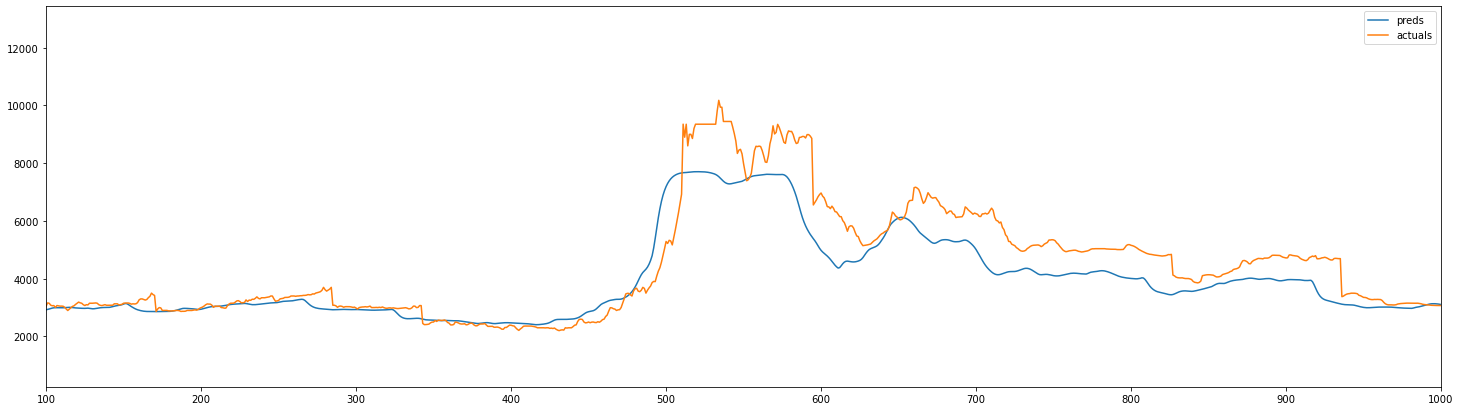

In [16]:
predictions.plot(figsize = (25, 7), xlim = [100, 1000])